Setup

In [1]:
import pandas as pd
import numpy as np
import talib as ta
import matplotlib.pyplot as plt
import seaborn as sns
import os

Data Loading

In [2]:
stock_data_files = {
    'AAPL': '../data/AAPL_historical_data.csv',  
    'AMZN': '../data/AMZN_historical_data.csv',  
    'GOOG': '../data/GOOG_historical_data.csv',  
    'META': '../data/META_historical_data.csv',  
    'NVDA': '../data/NVDA_historical_data.csv',  
    'TSLA': '../data/TSLA_historical_data.csv',  
    
}

# Define a directory to save the plots
plots_output_dir = './quantitative_plots'
os.makedirs(plots_output_dir, exist_ok=True)

# --- Load Data ---
print("--- Loading Stock Data ---")
all_stocks_df = [] # List to hold DataFrames for each stock

for symbol, file_path in stock_data_files.items():
    print(f"Loading data for {symbol} from: {file_path}")
    try:
        df_single_stock = pd.read_csv(file_path)
        # Add a 'STOCK_SYMBOL' column to identify the company
        df_single_stock['Stock Symbol'] = symbol
        all_stocks_df.append(df_single_stock)
        print(f"Successfully loaded data for {symbol}.")
    except FileNotFoundError:
        print(f"Error: File for {symbol} not found at '{file_path}'. Skipping this stock.")
    except Exception as e:
        print(f"An error occurred while loading data for {symbol}: {e}. Skipping this stock.")

if not all_stocks_df:
    print("No stock data was loaded. Exiting.")
    exit()

# Concatenate all individual stock DataFrames into one
df_raw = pd.concat(all_stocks_df, ignore_index=True)
print("\nAll stock data concatenated successfully.")
print("\nFirst 5 rows of the raw combined dataset:")
print(df_raw.head())
print("\nRaw Combined DataFrame Info:")
df_raw.info()
print(f"\nUnique stock symbols found: {df_raw['Stock Symbol'].nunique()}")
print(f"List of unique stock symbols: {df_raw['Stock Symbol'].unique()}")

--- Loading Stock Data ---
Loading data for AAPL from: ../data/AAPL_historical_data.csv
Successfully loaded data for AAPL.
Loading data for AMZN from: ../data/AMZN_historical_data.csv
Successfully loaded data for AMZN.
Loading data for GOOG from: ../data/GOOG_historical_data.csv
Successfully loaded data for GOOG.
Loading data for META from: ../data/META_historical_data.csv
Successfully loaded data for META.
Loading data for NVDA from: ../data/NVDA_historical_data.csv
Successfully loaded data for NVDA.
Loading data for TSLA from: ../data/TSLA_historical_data.csv
Successfully loaded data for TSLA.

All stock data concatenated successfully.

First 5 rows of the raw combined dataset:
         Date      Open      High       Low     Close  Adj Close     Volume  \
0  1980-12-12  0.128348  0.128906  0.128348  0.128348   0.098943  469033600   
1  1980-12-15  0.122210  0.122210  0.121652  0.121652   0.093781  175884800   
2  1980-12-16  0.113281  0.113281  0.112723  0.112723   0.086898  10572800

Data Preparation and Cleaning

In [3]:
# --- Data Preparation and Cleaning ---
print("\n--- Preparing and Cleaning Stock Data ---")

df_cleaned = df_raw.copy() # Work on a copy to preserve the raw data

# Standardize column names to uppercase for consistency and TA-Lib compatibility
df_cleaned.columns = [col.upper().replace(' ', '_') for col in df_cleaned.columns]

# Ensure 'DATE' column exists and convert to datetime
print(df_cleaned.columns)  # Debugging: print column names to check for 'DATE'
if 'DATE' in df_cleaned.columns:
    df_cleaned['DATE'] = pd.to_datetime(df_cleaned['DATE'], errors='coerce')
else:
    print("Error: 'DATE' column not found in the dataset after standardization.")
    exit()

# Drop rows where 'DATE' conversion failed (NaT)
df_cleaned.dropna(subset=['DATE'], inplace=True)

# Set 'DATE' as index, but keep 'STOCK_SYMBOL' as a regular column for grouping
# Sort by Stock Symbol first, then DATE to ensure correct chronological order within each stock
df_cleaned.sort_values(by=['STOCK_SYMBOL', 'DATE'], inplace=True)
df_cleaned.set_index('DATE', inplace=True)

# Handle missing values: forward fill within each stock group, then drop any remaining NaNs
# This ensures that data from one stock doesn't fill NaNs for another.
df_cleaned = df_cleaned.groupby('STOCK_SYMBOL', group_keys=False).apply(lambda group: group.fillna(method='ffill'))
df_cleaned.dropna(inplace=True) # Drop any remaining NaNs (e.g., at the start of a series)

# Convert numerical columns to appropriate types
numerical_cols = ['OPEN', 'HIGH', 'LOW', 'CLOSE', 'ADJ_CLOSE', 'VOLUME', 'DIVIDENDS', 'STOCK_SPLITS']
for col in numerical_cols:
    if col in df_cleaned.columns:
        df_cleaned[col] = pd.to_numeric(df_cleaned[col], errors='coerce')

# Drop rows where critical financial data might be NaN after conversion
df_cleaned.dropna(subset=['OPEN', 'HIGH', 'LOW', 'CLOSE', 'ADJ_CLOSE', 'VOLUME'], inplace=True)

if df_cleaned.empty:
    print("Warning: Stock DataFrame is empty after cleaning. Check your data.")
else:
    print("Stock data prepared and cleaned successfully.")
    print("Cleaned Stock DataFrame Info:")
    df_cleaned.info()
    print("\nCleaned Stock DataFrame Head (first few rows of each stock):")
    print(df_cleaned.groupby('STOCK_SYMBOL').head(2))
    print("\nCleaned Stock DataFrame Tail (last few rows of each stock):")
    print(df_cleaned.groupby('STOCK_SYMBOL').tail(2))



--- Preparing and Cleaning Stock Data ---
Index(['DATE', 'OPEN', 'HIGH', 'LOW', 'CLOSE', 'ADJ_CLOSE', 'VOLUME',
       'DIVIDENDS', 'STOCK_SPLITS', 'STOCK_SYMBOL'],
      dtype='object')
Stock data prepared and cleaned successfully.
Cleaned Stock DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35756 entries, 1980-12-12 to 2024-07-30
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   OPEN          35756 non-null  float64
 1   HIGH          35756 non-null  float64
 2   LOW           35756 non-null  float64
 3   CLOSE         35756 non-null  float64
 4   ADJ_CLOSE     35756 non-null  float64
 5   VOLUME        35756 non-null  int64  
 6   DIVIDENDS     35756 non-null  float64
 7   STOCK_SPLITS  35756 non-null  float64
 8   STOCK_SYMBOL  35756 non-null  object 
dtypes: float64(7), int64(1), object(1)
memory usage: 2.7+ MB

Cleaned Stock DataFrame Head (first few rows of each stock):
              

C:\Users\Perserverence\AppData\Local\Temp\ipykernel_20412\2785633626.py:27: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_cleaned = df_cleaned.groupby('STOCK_SYMBOL', group_keys=False).apply(lambda group: group.fillna(method='ffill'))
C:\Users\Perserverence\AppData\Local\Temp\ipykernel_20412\2785633626.py:27: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_cleaned = df_cleaned.groupby('STOCK_SYMBOL', group_keys=False).apply(lambda group: group.fillna(method='ffill'))


In [4]:
# --- Apply TA-Lib Technical Indicators (Per Stock) ---
print("\n--- Applying TA-Lib Indicators ---")

def apply_indicators_to_group(group):
    """Applies TA-Lib indicators to a single stock group."""
    if group.empty:
        return group

    # Ensure all required columns are available as numpy arrays for TA-Lib
    # TA-Lib functions typically expect numpy arrays
    try:
        open_price = np.array(group['OPEN'], dtype=float)
        high_price = np.array(group['HIGH'], dtype=float)
        low_price = np.array(group['LOW'], dtype=float)
        close_price = np.array(group['CLOSE'], dtype=float)
        volume = np.array(group['VOLUME'], dtype=float)
        adj_close_price = np.array(group['ADJ_CLOSE'], dtype=float) # Use Adj Close for indicators if preferred
    except KeyError as e:
        print(f"Warning: Missing critical column for TA-Lib calculation in group {group.name}: {e}")
        return group # Return original group if critical column is missing

    # Moving Averages (using Adj Close for robustness)
    group['SMA_10'] = ta.SMA(adj_close_price, timeperiod=10)
    group['EMA_20'] = ta.EMA(adj_close_price, timeperiod=20)
    group['SMA_50'] = ta.SMA(adj_close_price, timeperiod=50) # Longer term SMA

    # Relative Strength Index (RSI)
    group['RSI'] = ta.RSI(adj_close_price, timeperiod=14)

    # Moving Average Convergence Divergence (MACD)
    macd, macdsignal, macdhist = ta.MACD(adj_close_price, fastperiod=12, slowperiod=26, signalperiod=9)
    group['MACD'] = macd
    group['MACD_Signal'] = macdsignal
    group['MACD_Hist'] = macdhist

    # Bollinger Bands
    upper, middle, lower = ta.BBANDS(adj_close_price, timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
    group['BB_Upper'] = upper
    group['BB_Middle'] = middle
    group['BB_Lower'] = lower

    # Stochastic Oscillator
    fastk, fastd = ta.STOCH(high_price, low_price, adj_close_price,
                            fastk_period=5, slowk_period=3, slowk_matype=0,
                            slowd_period=3, slowd_matype=0)
    group['STOCH_K'] = fastk
    group['STOCH_D'] = fastd

    # Average True Range (ATR) - useful for volatility
    group['ATR'] = ta.ATR(high_price, low_price, adj_close_price, timeperiod=14)

    return group

# Apply the function to each stock group
df_with_ta = df_cleaned.groupby('STOCK_SYMBOL', group_keys=False).apply(apply_indicators_to_group)

print("TA-Lib indicators applied successfully to all stocks.")
print("\nDataFrame with new indicators (tail of a sample stock, e.g., first one alphabetically):")
# Get the first unique stock symbol to show a sample
sample_stock_symbol = df_with_ta['STOCK_SYMBOL'].unique()[0]
print(df_with_ta[df_with_ta['STOCK_SYMBOL'] == sample_stock_symbol].tail())



--- Applying TA-Lib Indicators ---
TA-Lib indicators applied successfully to all stocks.

DataFrame with new indicators (tail of a sample stock, e.g., first one alphabetically):
                  OPEN        HIGH         LOW       CLOSE   ADJ_CLOSE  \
DATE                                                                     
2024-07-24  224.000000  224.800003  217.130005  218.539993  218.287323   
2024-07-25  218.929993  220.850006  214.619995  217.490005  217.238556   
2024-07-26  218.699997  219.490005  216.009995  217.960007  217.708008   
2024-07-29  216.960007  219.300003  215.750000  218.240005  217.987686   
2024-07-30  219.190002  220.330002  216.119995  218.800003  218.547043   

              VOLUME  DIVIDENDS  STOCK_SPLITS STOCK_SYMBOL      SMA_10  ...  \
DATE                                                                    ...   
2024-07-24  61777600        0.0           0.0         AAPL  226.958298  ...   
2024-07-25  51391200        0.0           0.0         AAPL  225.9

C:\Users\Perserverence\AppData\Local\Temp\ipykernel_20412\3104056270.py:55: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_with_ta = df_cleaned.groupby('STOCK_SYMBOL', group_keys=False).apply(apply_indicators_to_group)


In [5]:
# --- Calculate Financial Metrics (Per Stock) ---
print("\n--- Calculating Financial Metrics ---")

def calculate_metrics_to_group(group):
    """Calculates common financial metrics for a single stock group."""
    if group.empty:
        return group

    # Daily Returns: Percentage change from previous day's adjusted close
    group['Daily_Return'] = group['ADJ_CLOSE'].pct_change()

    # Cumulative Returns: Compounded returns over the period
    # Fill NA with 0 for the first day's return to avoid issues with cumprod
    group['Cumulative_Return'] = (1 + group['Daily_Return'].fillna(0)).cumprod() - 1

    # Rolling Volatility: Standard deviation of daily returns over a rolling window
    # Using a 20-day rolling window (approx. 1 month of trading days)
    # Annualized by multiplying by sqrt(252) for ~252 trading days in a year
    group['Rolling_Volatility_20D'] = group['Daily_Return'].rolling(window=20).std() * np.sqrt(252)

    return group

# Apply the function to each stock group
df_final = df_with_ta.groupby('STOCK_SYMBOL', group_keys=False).apply(calculate_metrics_to_group)

# Drop rows with NaN values introduced by rolling calculations (e.g., first N rows for N-period indicators)
df_final.dropna(inplace=True)

print("Financial metrics calculated successfully for all stocks.")
print("\nDataFrame with new metrics (tail of a sample stock):")
# Re-get the first unique stock symbol as some rows might have been dropped
if not df_final.empty:
    sample_stock_symbol_final = df_final['STOCK_SYMBOL'].unique()[0]
    print(df_final[df_final['STOCK_SYMBOL'] == sample_stock_symbol_final].tail())
else:
    print("DataFrame is empty after dropping NaNs from indicator and metric calculations.")



--- Calculating Financial Metrics ---
Financial metrics calculated successfully for all stocks.

DataFrame with new metrics (tail of a sample stock):
                  OPEN        HIGH         LOW       CLOSE   ADJ_CLOSE  \
DATE                                                                     
2024-07-24  224.000000  224.800003  217.130005  218.539993  218.287323   
2024-07-25  218.929993  220.850006  214.619995  217.490005  217.238556   
2024-07-26  218.699997  219.490005  216.009995  217.960007  217.708008   
2024-07-29  216.960007  219.300003  215.750000  218.240005  217.987686   
2024-07-30  219.190002  220.330002  216.119995  218.800003  218.547043   

              VOLUME  DIVIDENDS  STOCK_SPLITS STOCK_SYMBOL      SMA_10  ...  \
DATE                                                                    ...   
2024-07-24  61777600        0.0           0.0         AAPL  226.958298  ...   
2024-07-25  51391200        0.0           0.0         AAPL  225.951463  ...   
2024-07-26  41

C:\Users\Perserverence\AppData\Local\Temp\ipykernel_20412\4030227387.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_final = df_with_ta.groupby('STOCK_SYMBOL', group_keys=False).apply(calculate_metrics_to_group)



--- Generating Visualizations ---
Generating plots for sample stock: AAPL


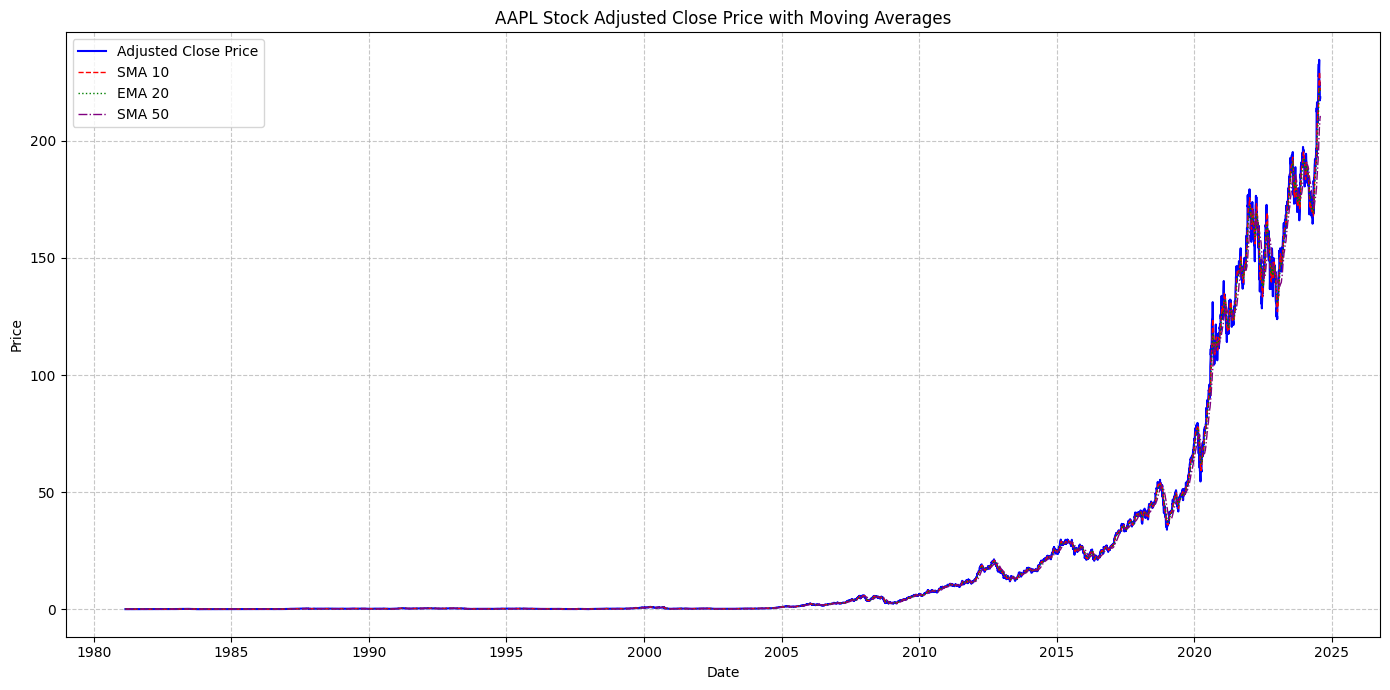

Plot saved to ./quantitative_plots\AAPL_close_price_with_mas.png


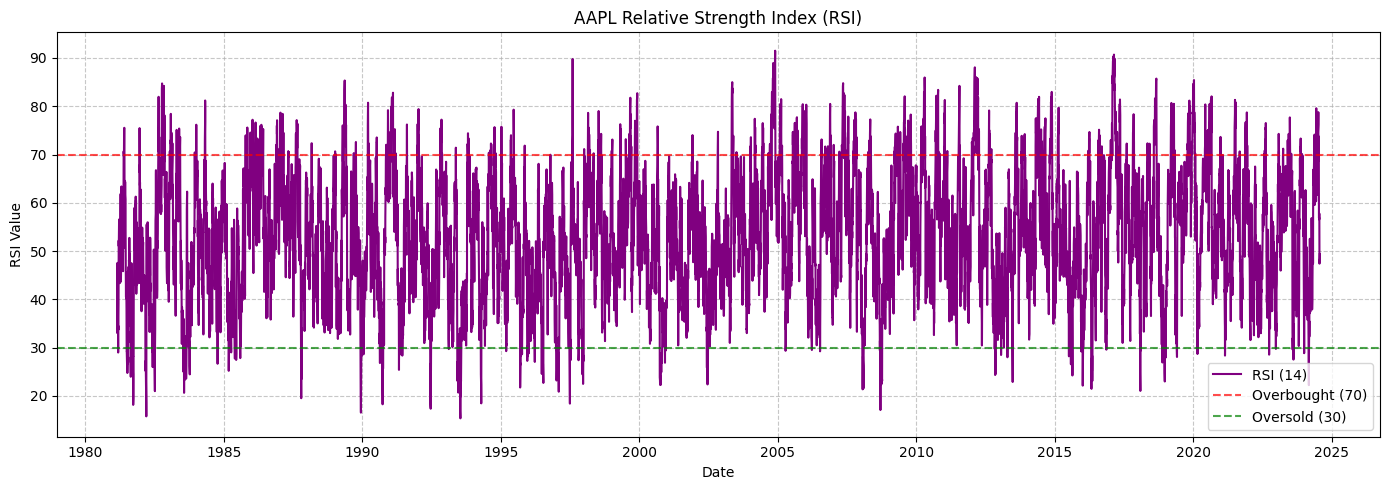

Plot saved to ./quantitative_plots\AAPL_rsi_plot.png


C:\Users\Perserverence\AppData\Local\Temp\ipykernel_20412\3310641473.py:66: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(os.path.join(plots_output_dir, f'{sample_stock_to_plot}_macd_plot.png'))


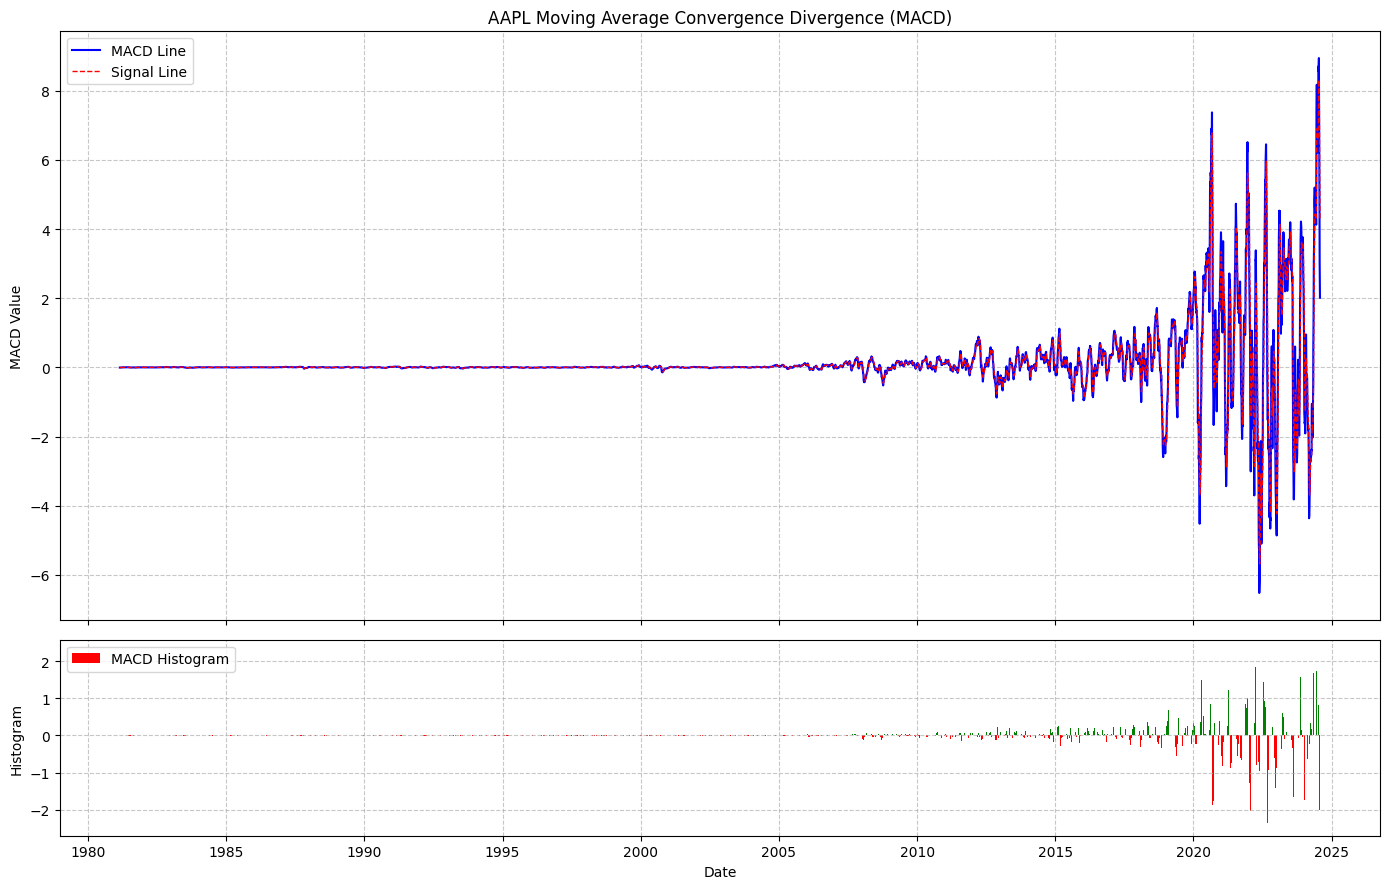

Plot saved to ./quantitative_plots\AAPL_macd_plot.png


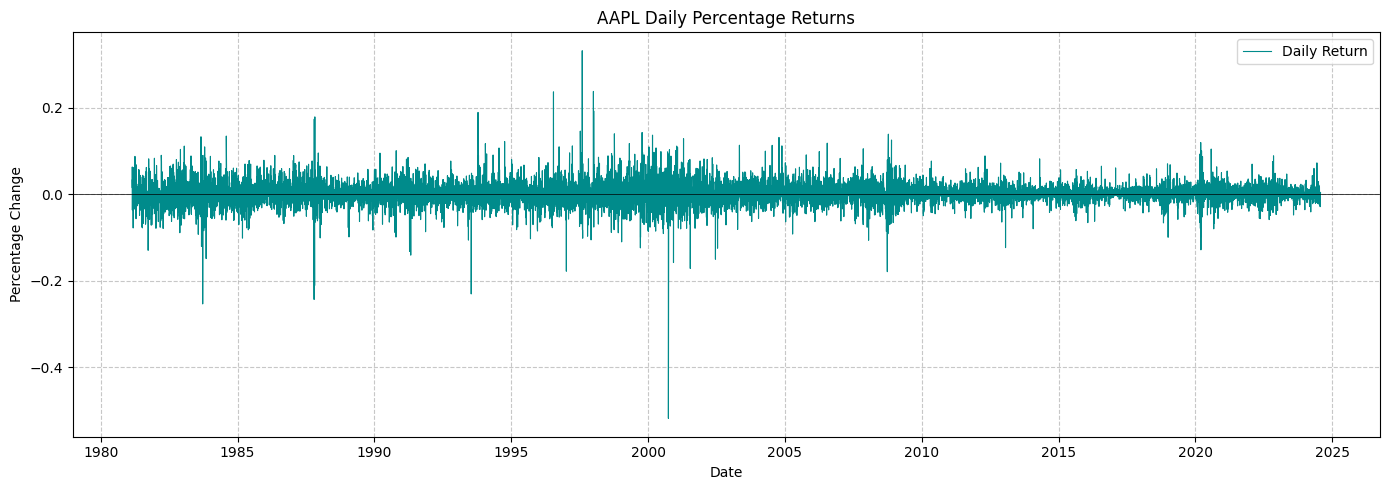

Plot saved to ./quantitative_plots\AAPL_daily_returns_plot.png


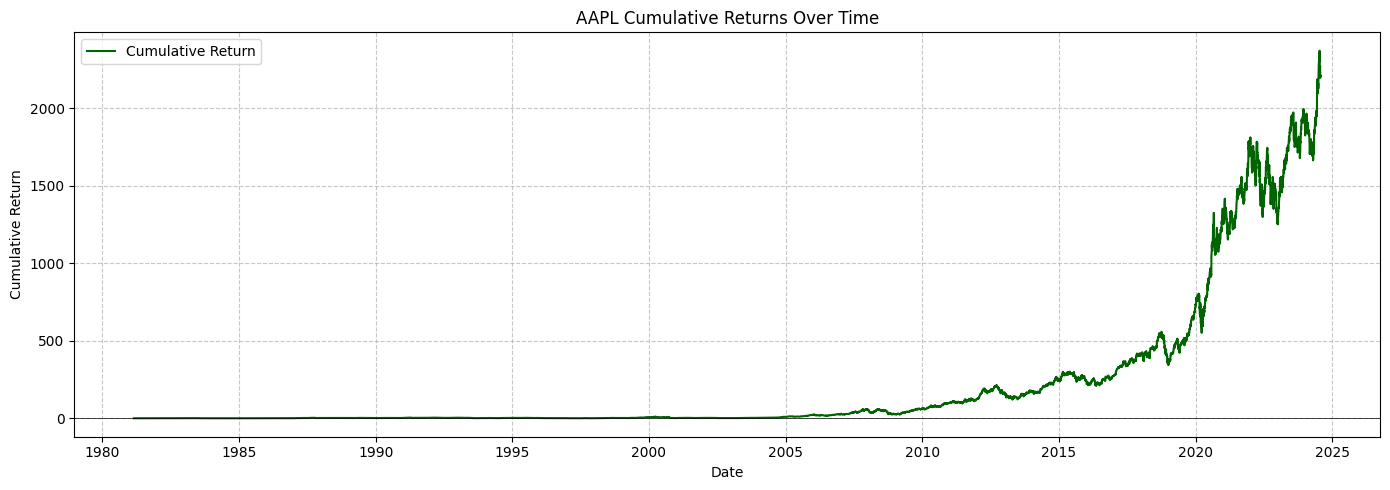

Plot saved to ./quantitative_plots\AAPL_cumulative_returns_plot.png

All visualizations generated for the sample stock. Check the 'quantitative_plots' directory.


In [6]:
# --- Visualization (for a sample stock) ---
print("\n--- Generating Visualizations ---")

if df_final.empty:
    print("Cannot generate visualizations: Final DataFrame is empty.")
else:
    # Select a sample stock for visualization
    # You can change this to any of your 7 company symbols, e.g., 'MSFT', 'GOOG', etc.
    sample_stock_to_plot = df_final['STOCK_SYMBOL'].unique()[0]
    print(f"Generating plots for sample stock: {sample_stock_to_plot}")
    df_plot = df_final[df_final['STOCK_SYMBOL'] == sample_stock_to_plot].copy()

    if df_plot.empty:
        print(f"No data available for {sample_stock_to_plot} after cleaning and calculations. Skipping plots.")
    else:
        # Plot 1: Close Price with Moving Averages
        plt.figure(figsize=(14, 7))
        plt.plot(df_plot.index, df_plot['ADJ_CLOSE'], label='Adjusted Close Price', color='blue', linewidth=1.5)
        plt.plot(df_plot.index, df_plot['SMA_10'], label='SMA 10', color='red', linestyle='--', linewidth=1)
        plt.plot(df_plot.index, df_plot['EMA_20'], label='EMA 20', color='green', linestyle=':', linewidth=1)
        plt.plot(df_plot.index, df_plot['SMA_50'], label='SMA 50', color='purple', linestyle='-.', linewidth=1)
        plt.title(f'{sample_stock_to_plot} Stock Adjusted Close Price with Moving Averages')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.savefig(os.path.join(plots_output_dir, f'{sample_stock_to_plot}_close_price_with_mas.png'))
        plt.show()
        print(f"Plot saved to {os.path.join(plots_output_dir, f'{sample_stock_to_plot}_close_price_with_mas.png')}")

        # Plot 2: RSI
        plt.figure(figsize=(14, 5))
        plt.plot(df_plot.index, df_plot['RSI'], label='RSI (14)', color='purple')
        plt.axhline(70, linestyle='--', color='red', alpha=0.7, label='Overbought (70)')
        plt.axhline(30, linestyle='--', color='green', alpha=0.7, label='Oversold (30)')
        plt.title(f'{sample_stock_to_plot} Relative Strength Index (RSI)')
        plt.xlabel('Date')
        plt.ylabel('RSI Value')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.savefig(os.path.join(plots_output_dir, f'{sample_stock_to_plot}_rsi_plot.png'))
        plt.show()
        print(f"Plot saved to {os.path.join(plots_output_dir, f'{sample_stock_to_plot}_rsi_plot.png')}")

        # Plot 3: MACD
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 9), sharex=True,
                                       gridspec_kw={'height_ratios': [3, 1]})

        ax1.plot(df_plot.index, df_plot['MACD'], label='MACD Line', color='blue', linewidth=1.5)
        ax1.plot(df_plot.index, df_plot['MACD_Signal'], label='Signal Line', color='red', linestyle='--', linewidth=1)
        ax1.set_title(f'{sample_stock_to_plot} Moving Average Convergence Divergence (MACD)')
        ax1.set_ylabel('MACD Value')
        ax1.legend()
        ax1.grid(True, linestyle='--', alpha=0.7)

        colors = ['green' if val >= 0 else 'red' for val in df_plot['MACD_Hist']]
        ax2.bar(df_plot.index, df_plot['MACD_Hist'], color=colors, label='MACD Histogram')
        ax2.set_xlabel('Date')
        ax2.set_ylabel('Histogram')
        ax2.grid(True, linestyle='--', alpha=0.7)
        ax2.legend()

        plt.tight_layout()
        plt.savefig(os.path.join(plots_output_dir, f'{sample_stock_to_plot}_macd_plot.png'))
        plt.show()
        print(f"Plot saved to {os.path.join(plots_output_dir, f'{sample_stock_to_plot}_macd_plot.png')}")

        # Plot 4: Daily Returns
        plt.figure(figsize=(14, 5))
        plt.plot(df_plot.index, df_plot['Daily_Return'], label='Daily Return', color='darkcyan', linewidth=0.8)
        plt.axhline(0, color='black', linestyle='-', linewidth=0.5)
        plt.title(f'{sample_stock_to_plot} Daily Percentage Returns')
        plt.xlabel('Date')
        plt.ylabel('Percentage Change')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.savefig(os.path.join(plots_output_dir, f'{sample_stock_to_plot}_daily_returns_plot.png'))
        plt.show()
        print(f"Plot saved to {os.path.join(plots_output_dir, f'{sample_stock_to_plot}_daily_returns_plot.png')}")

        # Plot 5: Cumulative Returns
        plt.figure(figsize=(14, 5))
        plt.plot(df_plot.index, df_plot['Cumulative_Return'], label='Cumulative Return', color='darkgreen', linewidth=1.5)
        plt.axhline(0, color='black', linestyle='-', linewidth=0.5)
        plt.title(f'{sample_stock_to_plot} Cumulative Returns Over Time')
        plt.xlabel('Date')
        plt.ylabel('Cumulative Return')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.savefig(os.path.join(plots_output_dir, f'{sample_stock_to_plot}_cumulative_returns_plot.png'))
        plt.show()
        print(f"Plot saved to {os.path.join(plots_output_dir, f'{sample_stock_to_plot}_cumulative_returns_plot.png')}")

        print("\nAll visualizations generated for the sample stock. Check the 'quantitative_plots' directory.")

